<a href="https://colab.research.google.com/github/vvshyer/tensorflow2.0_learning/blob/master/tf_keras_regression_customized_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0-alpha0
sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)
matplotlib 3.0.3
numpy 1.16.3
pandas 0.24.2
sklearn 0.21.2
tensorflow 2.0.0-alpha0
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
from sklearn.model_selection import train_test_split

# test_size默认为0.25
x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7, test_size = 0.25)

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [15]:
# tf.nn.softplus: log(1+e^x)
customized_softplus = keras.layers.Lambda(lambda x: tf.nn.softplus(x))
print(customized_softplus([-10., -5., 0., 5., 10.]))

tf.Tensor([4.5417706e-05 6.7153489e-03 6.9314718e-01 5.0067153e+00 1.0000046e+01], shape=(5,), dtype=float32)


In [16]:
# customized dense layer
class CustomizedDenseLayer(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        self.units = units
        self.activation = keras.layers.Activation(activation)
        super(CustomizedDenseLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        """构建所需要的参数"""
        self.kernel = self.add_weight(name = "kernel",
                                      shape = (input_shape[1], self.units),
                                      initializer = 'uniform',
                                      trainable = True)
        self.bias = self.add_weight(name = "bias",
                                    shape = (self.units,),
                                    initializer = 'zeros',
                                    trainable = True)
        super(CustomizedDenseLayer, self).build(input_shape)
    
    def call(self, x):
        return self.activation(x @ self.kernel + self.bias)

model = keras.models.Sequential([
    CustomizedDenseLayer(30, activation='relu',
                       input_shape=x_train.shape[1:]),
    CustomizedDenseLayer(1),
    customized_softplus,
    # keras.layers.Dense(1, activation="softplus"),
    # keras.layers.Dense(1), keras.layers.Activation("softplus"),
])
model.summary()
model.compile(loss="mean_squared_error", optimizer = "sgd")
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
customized_dense_layer_4 (Cu (None, 30)                270       
_________________________________________________________________
customized_dense_layer_5 (Cu (None, 1)                 31        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(x_train_scaled, y_train,
                   validation_data = (x_valid_scaled, y_valid),
                   epochs = 100,
                   callbacks = callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 47us/sample - loss: 2.7886 - val_loss: 2.5886
Epoch 2/100
11610/11610 [==============================] - 0s 37us/sample - loss: 2.0985 - val_loss: 1.9169
Epoch 3/100
11610/11610 [==============================] - 0s 38us/sample - loss: 1.5352 - val_loss: 1.3846
Epoch 4/100
11610/11610 [==============================] - 0s 37us/sample - loss: 1.1036 - val_loss: 0.9833
Epoch 5/100
11610/11610 [==============================] - 0s 37us/sample - loss: 0.8304 - val_loss: 0.7897
Epoch 6/100
11610/11610 [==============================] - 0s 34us/sample - loss: 0.7216 - val_loss: 0.7299
Epoch 7/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.6819 - val_loss: 0.7056
Epoch 8/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.6606 - val_loss: 0.6902
Epoch 9/100
11610/11610 [==============================] - 0s 34us/sample - loss: 0.645

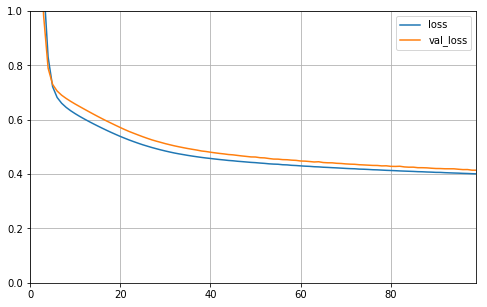

In [18]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

plot_learning_curves(history)

In [19]:
model.evaluate(x_test_scaled, y_test)

5160/5160 [==============================] - 0s 18us/sample - loss: 0.4167


0.4167179967081824